In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotnine as p9
import requests_cache
requests_cache.install_cache('weather_cache')
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
Token = "pVNnatMYsXAaijcyPESlaNXivnMrJtFk"
params = {'datasetid': 'GHCND', 'datatypeid': 'TMAX','limit': '1000', 'stationid': 'GHCND:USW00023174', \
          'units': 'standard', 'startdate': '2000-01-01','enddate': '2000-12-31'}
req = requests.get(url,params=params,headers={'token':Token})
js = req.json()
req.url

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&enddate=2000-12-31&limit=1000&startdate=2000-01-01&stationid=GHCND%3AUSW00023174&units=standard'

In [3]:
year =  list(range(2000,2021))
df = pd.DataFrame()
for i in year:
    params['startdate'] = str(i)+'-01-01'
    params['enddate'] = str(i)+'-12-31'
    params['datatypeid'] = 'TMAX'
    tmax = requests.get(url,params=params,headers={'token':Token})
    tmax_temp = pd.DataFrame(tmax.json()['results'])
    tmax_temp['date'] = pd.to_datetime(tmax_temp['date'])
    tmax_temp = tmax_temp.rename(columns={"value": "max_temperature"})
    tmax_temp = tmax_temp.set_index('date').drop(['datatype'], axis=1)
    
    params['datatypeid'] = 'TMIN'
    tmin = requests.get(url,params=params,headers={'token':Token})
    tmin_temp = pd.DataFrame(tmin.json()['results'])
    tmin_temp['date'] = pd.to_datetime(tmin_temp['date'])
    tmin_temp = tmin_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    tmin_temp = tmin_temp.rename(columns={"value": "min_temperature"})
    df_temp = tmax_temp.join(tmin_temp)
    
    params['datatypeid'] = 'PRCP'
    prcp = requests.get(url,params=params,headers={'token':Token})
    prcp_temp = pd.DataFrame(prcp.json()['results'])
    prcp_temp['date'] = pd.to_datetime(prcp_temp['date'])
    prcp_temp = prcp_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    prcp_temp = prcp_temp.rename(columns={"value": "rain"})
    df_temp = df_temp.join(prcp_temp)
    
    df = pd.concat([df, df_temp])

In [4]:
df['diff'] = df.eval('max_temperature - min_temperature')
df

,station,attributes,max_temperature,min_temperature,rain,diff
date,,,,,,
2000-01-01,GHCND:USW00023174,",,0,2400",58.0,46.0,0.00,12.0
2000-01-02,GHCND:USW00023174,",,0,2400",60.0,48.0,0.00,12.0
2000-01-03,GHCND:USW00023174,",,0,2400",66.0,44.0,0.00,22.0
2000-01-04,GHCND:USW00023174,",,0,2400",69.0,47.0,0.00,22.0
2000-01-05,GHCND:USW00023174,",,0,2400",70.0,43.0,0.00,27.0
...,...,...,...,...,...,...
2020-12-27,GHCND:USW00023174,",,W,2400",64.0,52.0,0.00,12.0
2020-12-28,GHCND:USW00023174,",,W,2400",55.0,45.0,1.63,10.0
2020-12-29,GHCND:USW00023174,",,W,2400",65.0,42.0,0.00,23.0


In [5]:
mon_df = df.copy()
#mon_df.index = mon_df.index.month_name()
mon_df.index = mon_df.index.to_period('M')
mon_df = mon_df.reset_index()

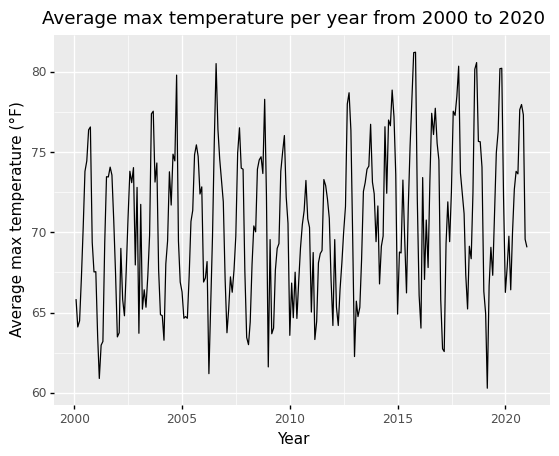

<ggplot: (151103742600)>

In [6]:
mon_df_mean = mon_df.groupby(['date']).mean().reset_index()
p9.ggplot(mon_df_mean) + p9.aes(x='date',y='max_temperature',group = 1) + p9.geom_line() + \
p9.scale_x_datetime(breaks = date_breaks('5 years'), labels=date_format('%Y')) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020")

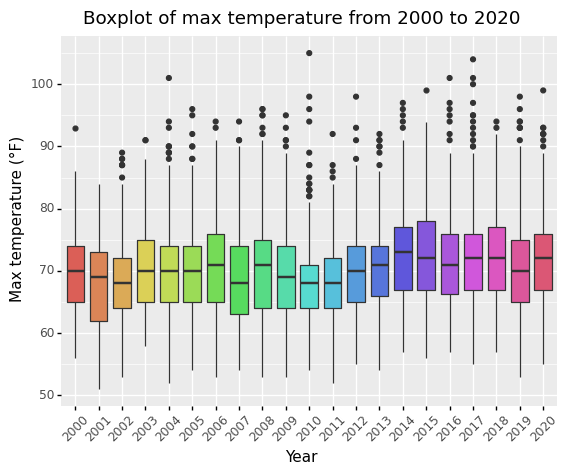

<ggplot: (151099124215)>

In [7]:
year_df = df.copy()
year_df.index = year_df.index.year
year_df = year_df.reset_index()
year_df['date'] = year_df['date'].astype(str)

p9.ggplot(year_df) + p9.aes(x='date',y='max_temperature',fill='date') + p9.geom_boxplot() + \
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + p9.guides(fill = False) + \
p9.labs(x = "Year", y = "Max temperature (°F)", \
     title = "Boxplot of max temperature from 2000 to 2020")

In [8]:
year_2000 = year_df.loc[year_df['date'] == '2000','max_temperature']
year_2020 = year_df.loc[year_df['date'] == '2020','max_temperature']
print(year_2000.mean())
print(year_2020.mean())
#Two sample t-test
print(stats.ttest_ind(a=year_2020,b=year_2000,alternative='greater'))
# 95% C.I. for 2000 and 2020
print(stats.t.interval(alpha=0.95, df=len(year_2000)-1, loc=np.mean(year_2000), scale=stats.sem(year_2000)))
print(stats.t.interval(alpha=0.95, df=len(year_2020)-1, loc=np.mean(year_2020), scale=stats.sem(year_2020)))

69.80601092896175
72.14480874316939
Ttest_indResult(statistic=4.7228488797921955, pvalue=1.3946412984367177e-06)
(69.1578012871906, 70.45422057073291)
(71.41806821953149, 72.87154926680729)


In [18]:
grps = [d['max_temperature'].tolist() for _, d in year_df.groupby('date')]
print(stats.f_oneway(*grps))
print(stats.kruskal(*grps))

F_onewayResult(statistic=14.944670404125699, pvalue=1.6774447378761491e-50)
KruskalResult(statistic=285.2084241984763, pvalue=8.381127303138626e-49)


C:\Users\jingh\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator


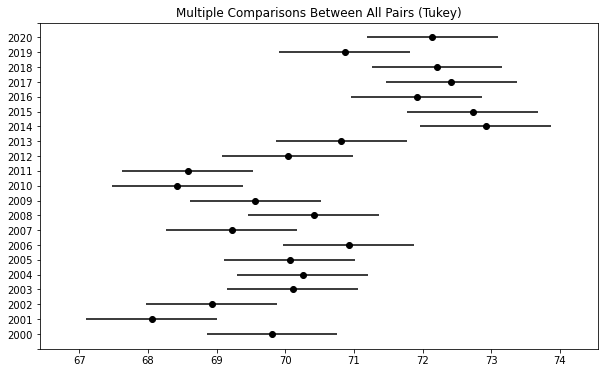

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=year_df['max_temperature'],groups=year_df['date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()

In [11]:
grps = [d['rain'].tolist() for _, d in year_df.groupby('date')]
stats.f_oneway(*grps)

F_onewayResult(statistic=2.3541874233167484, pvalue=0.0005876015555899757)

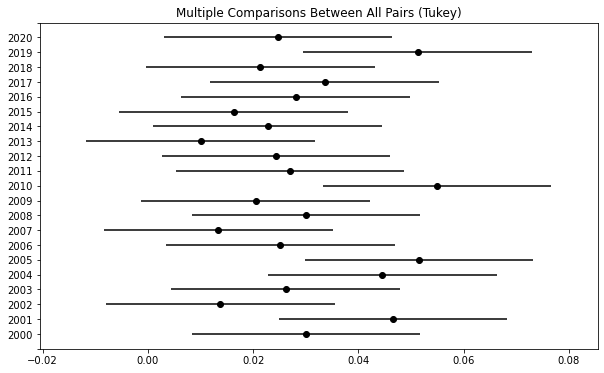

In [15]:
tukey = pairwise_tukeyhsd(endog=year_df['rain'],groups=year_df['date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()

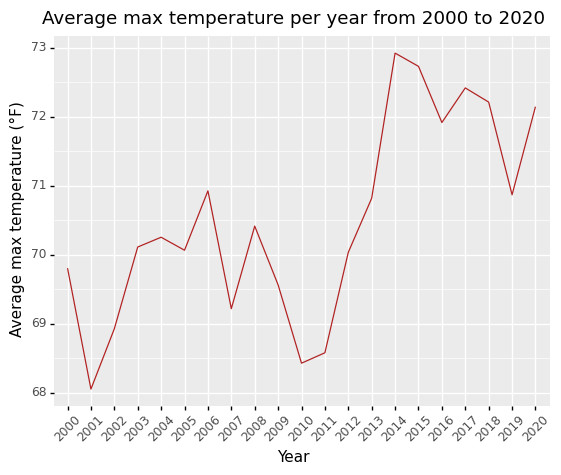

<ggplot: (160727781539)>

In [11]:
year_df_mean = year_df.groupby(['date']).mean().reset_index()
p9.ggplot(year_df_mean) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020")

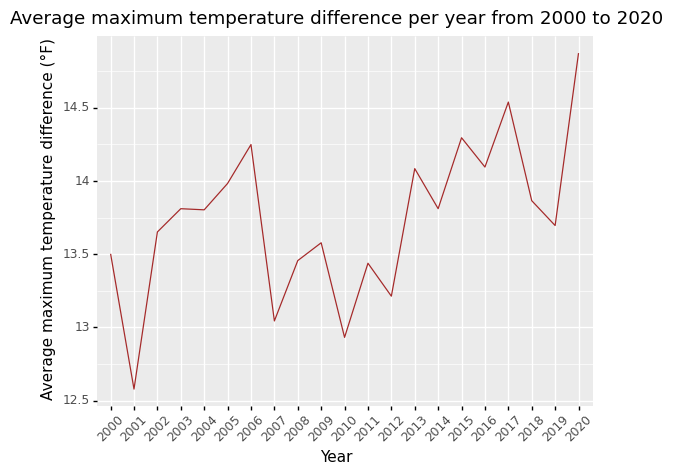

<ggplot: (160729791732)>

In [12]:
p9.ggplot(year_df_mean) + p9.aes(x='date',y='diff',group = 1) + \
p9.geom_line(color='brown') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average maximum temperature difference (°F)", \
     title = "Average maximum temperature difference per year from 2000 to 2020")

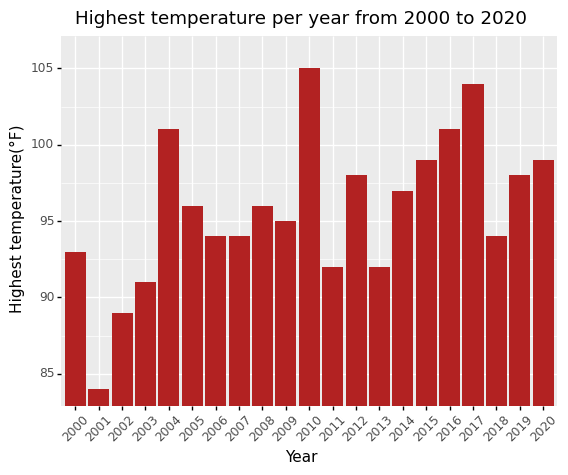

<ggplot: (160729743894)>

In [13]:
year_df_max = year_df.groupby(['date']).max().reset_index()
p9.ggplot(year_df_max) + p9.aes(x='date',y='max_temperature') + \
p9.geom_col(fill='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.coord_cartesian(ylim = [84, 106]) + \
p9.labs(x = "Year", y = "Highest temperature(°F)", \
     title = "Highest temperature per year from 2000 to 2020")

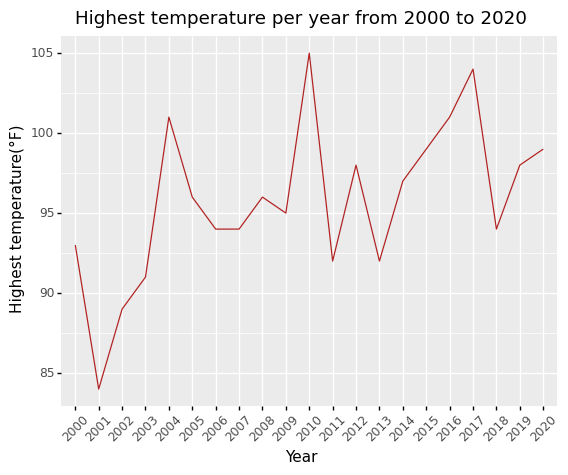

<ggplot: (160729785962)>

In [14]:
p9.ggplot(year_df_max) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Highest temperature(°F)", \
     title = "Highest temperature per year from 2000 to 2020")

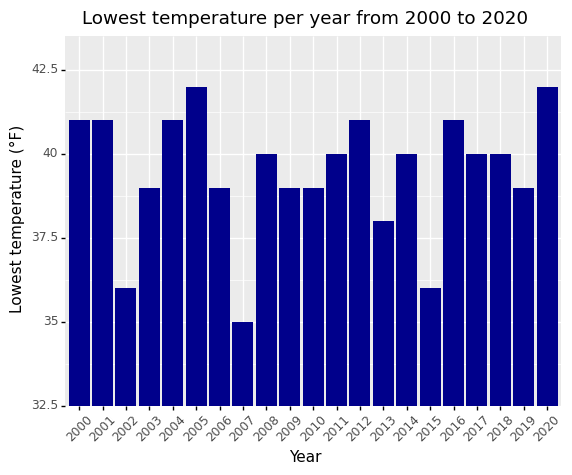

<ggplot: (160729906472)>

In [15]:
year_df_min = year_df.groupby(['date']).min().reset_index()
p9.ggplot(year_df_min) + p9.aes(x='date',y='min_temperature') + \
p9.geom_col(fill='darkblue') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.coord_cartesian(ylim = [33, 43]) + \
p9.labs(x = "Year", y = "Lowest temperature (°F)", \
     title = "Lowest temperature per year from 2000 to 2020")

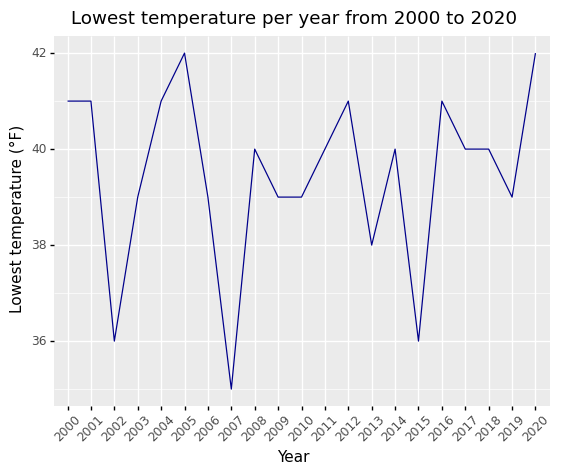

<ggplot: (160730204263)>

In [16]:
year_df_min = year_df.groupby(['date']).min().reset_index()
p9.ggplot(year_df_min) + p9.aes(x='date',y='min_temperature',group = 1) + \
p9.geom_line(color='darkblue') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Lowest temperature (°F)", \
     title = "Lowest temperature per year from 2000 to 2020")

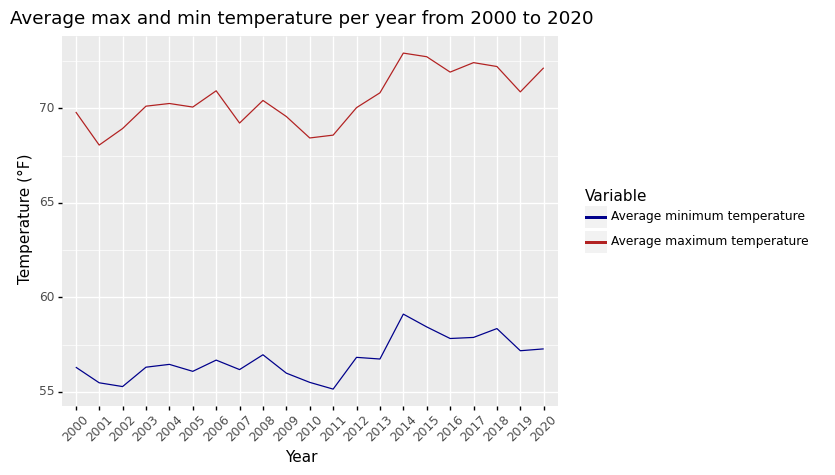

<ggplot: (160729935620)>

In [17]:
p9.ggplot(year_df_mean, p9.aes(x='date',y='min_temperature',group = 1)) + \
p9.geom_line(p9.aes(y='min_temperature', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='max_temperature', color='"firebrick"')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020")

In [18]:
season_df = df.copy()
season_df['year'] = season_df.index.year
season_df['month']= season_df.index.month
season_df = season_df.reset_index()
season_df['month'] = season_df['month'].astype(int)
season_df['season'] = season_df['month']%12 // 3 + 1

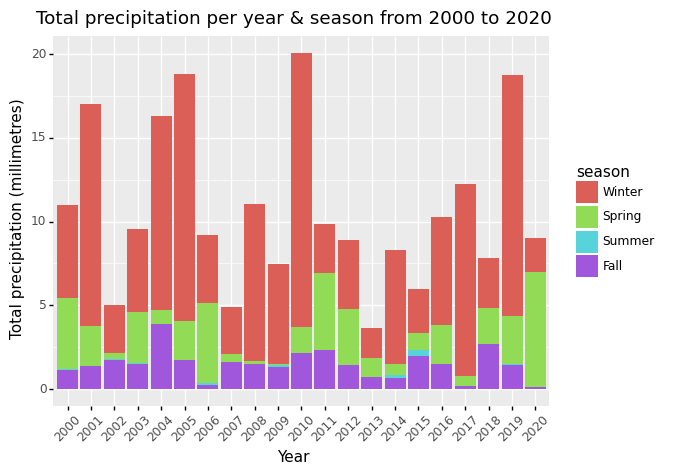

<ggplot: (160730237016)>

In [19]:
season_df_sum = season_df.groupby(['year','season']).sum().reset_index()
season_df_sum['year'] = season_df_sum['year'].astype(str)
season_df_sum['season'] = season_df_sum['season'].astype(str)
p9.ggplot(season_df_sum) + p9.aes(x='year',y='rain',fill='season') + \
p9.geom_col() + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.scale_fill_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Year", y = "Total precipitation (millimetres)", \
     title = "Total precipitation per year & season from 2000 to 2020")

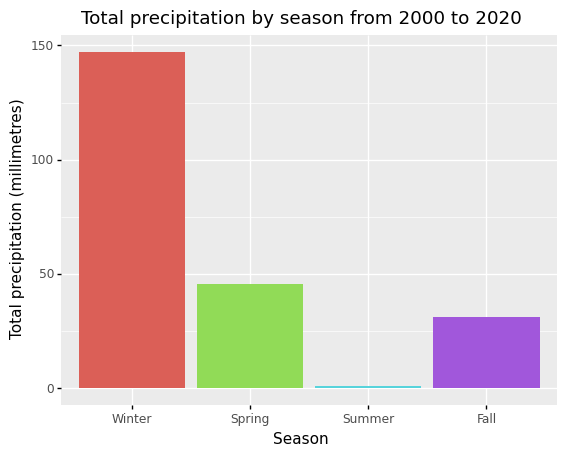

<ggplot: (160730784196)>

In [20]:
p9.ggplot(season_df_sum) + p9.aes(x='season',y='rain',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

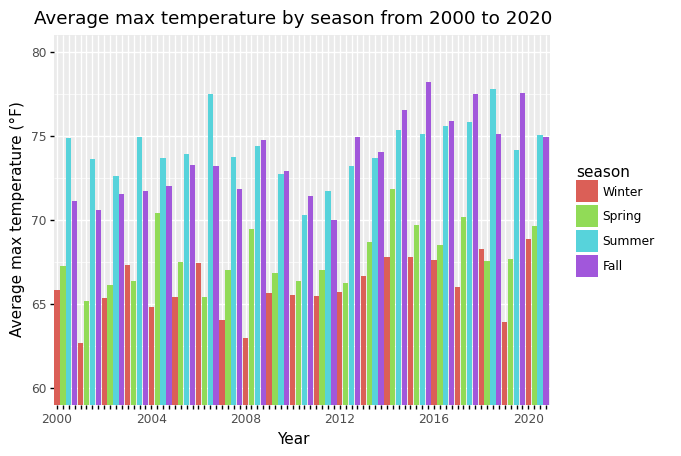

<ggplot: (160729781014)>

In [21]:
x_label = list()
x = 2000
for i in range(84):
    if i%16 == 0:
        x_label.append(str(x)) 
        x += 4
    else:
        x_label.append('')
        
season_df_mean = season_df.groupby(['year','season']).mean().reset_index()
season_df_mean['year'] = season_df_mean['year'].astype(str)
season_df_mean['season'] = season_df_mean['season'].astype(str)


season_df_mean['year_season'] = season_df_mean['year'].astype(str) + "," + season_df_mean['season'].astype(str)
p9.ggplot(season_df_mean) + p9.aes(x='year_season',y='max_temperature',fill='season') + p9.geom_col() + \
p9.scale_x_discrete(labels = x_label) + p9.coord_cartesian(ylim = [60, 80]) + \
p9.scale_fill_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature by season from 2000 to 2020")

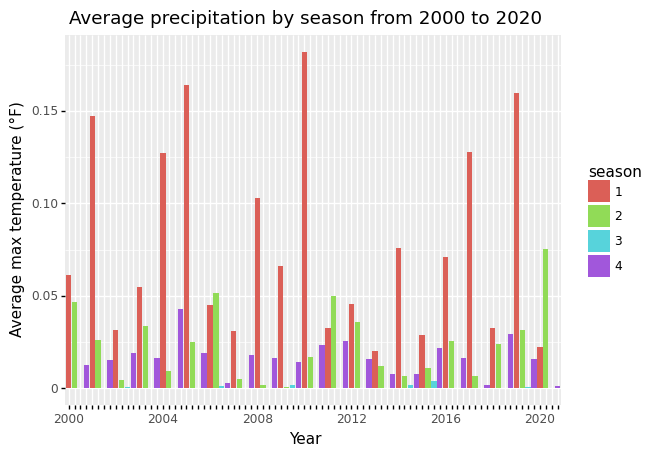

<ggplot: (160730256177)>

In [22]:
p9.ggplot(season_df_mean) + p9.aes(x='year_season',y='rain',fill='season') + p9.geom_col() + \
p9.scale_x_discrete(labels = x_label) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average precipitation by season from 2000 to 2020")